## DD2424 deep19 VT19-1 Deep Learning in Data Science - Assignment 4

### Table of Content



[Exercise 1 - 0.1](#0.1) -  Read in the data   
[Exercise 1 - 0.2](#0.2) -  Set hyper-parameters & initialize the RNN’s parameters   
[Exercise 1 - 0.3](#0.3) -  Synthesize text from your randomly initialized RNN   
[Exercise 1 - 0.4](#0.4) -  Implement the [forward](#0.4) with [loss](#loss) & [backward pass](#back) of the back-prop    
[Exercise 1 - 0.4 - b](#check) - Check correctness with [numerical gradient](#num)  
[Exercise 1 - 0.5](#0.5) - Train your RNN using AdaGrad   
[Training output and Loss Graph!](#output)  
[Best model writes !!!](#best)  

### Report
1. Computed Numerical Gradient and Analytical gradient and check [error](#check) <10^-7
2. Training [Graph](#output) with smoothed loss and loss for +2 epochs  
3. Evolution of generated [text](#evolution) sampling every 10,000 for first 100,000 steps of training. 
4. [Passage](#best) of length 1000 characters synthesized from your best model 
            Loss - 25.548408663992184
            Smoothed Loss - 46.77587470482475
            Iteration - 126000 
   Interesting words relatable to Harry Potter that the best model generated (from over 1000's of trails)- 
            
            harry peter (Close)
            harry  (Very often)
            hermione (Yes!)
            lord  (You-Know-Who)
            magic
            death     
            crooked 

In [2]:
import numpy as np
import math
from PIL import Image as Img
import pickle
from scipy import misc

import sys
import os.path

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import pprint
from ipywidgets import *
from IPython.display import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(400)

#### Exercise 1  0. 1
<a id='0.1'></a>
### Read in the data  

In [3]:
book_data = open('goblet_book.txt', 'r').read()
book_data = book_data.lower()
book_chars = list(set(book_data))
data_size, vocab_size = len(book_data), len(book_chars)
K = vocab_size
print('There are %d total characters and %d unique characters in the data.' % (data_size, vocab_size))

There are 1107542 total characters and 54 unique characters in the data.


In [4]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(book_chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(book_chars)) }
print(ix_to_char)

{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: '"', 5: "'", 6: '(', 7: ')', 8: ',', 9: '-', 10: '.', 11: '/', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '6', 18: '7', 19: '9', 20: ':', 21: ';', 22: '?', 23: '^', 24: '_', 25: 'a', 26: 'b', 27: 'c', 28: 'd', 29: 'e', 30: 'f', 31: 'g', 32: 'h', 33: 'i', 34: 'j', 35: 'k', 36: 'l', 37: 'm', 38: 'n', 39: 'o', 40: 'p', 41: 'q', 42: 'r', 43: 's', 44: 't', 45: 'u', 46: 'v', 47: 'w', 48: 'x', 49: 'y', 50: 'z', 51: '}', 52: 'ü', 53: '•'}


### 0.2 Set hyper-parameters & initialize the RNN’s parameters
<a id='0.2' />

In [5]:
m = 100 # Hidden states
eta = 0.1 #?
seq_length = 25
sig = 0.01

parameters = {}
parameters['b'] = np.zeros((m,1))
parameters['c'] = np.zeros((K,1))
parameters['U'] = np.random.rand(m,K)*sig
parameters['W'] = np.random.rand(m,m)*sig
parameters['V'] = np.random.rand(K,m)*sig

### 0.3 Synthesize text from your randomly initialized RNN
<a id='0.3' />

In [6]:
def softmax(x):
    """
    Instead of using np.exp(x)/np.sum(np.exp(x))
    I decrease the value of x with the max, 
    it could be any number as it cancels out when equation is expanded
    This is to avoid overflow due to exponential increase
    
    Argumets:
    x -- Product W, X
    
    Returns:
    soft -- softmax(W,X)
    """
    e_x = np.exp(x - np.max(x, axis = 0))
    soft = e_x / np.sum(e_x, axis = 0)
    return soft

In [7]:
def synthesize_seq(h0, x0, n, parameters):
    """
    synthesize a sequence of characters 

    Arguments:
    h0 -- the hidden state at time 0
    x0 -- the first (dummy) input vector  (as one-hot)
    n --  the length of the sequence you want to generate
    parameters -- RNN parameters weights, bias and stuff
    
    Returns:
    Synthesized sequence
    """ 
    
    synthesized_seq = [] #output
    ht = h0 # First state 
    xt = x0 # First one-hot input of the seq 
    
    for i in range(n):
        # 1. from x get discrete probability distribution of labels
        at = parameters['W'].dot(ht) + parameters['U'].dot(xt) + parameters['b']
        ht = np.tanh(at)
        ot = parameters['V'].dot(ht) + parameters['c']
        pt = softmax(ot)
        # 2. Pick one out of them as next input
        char_ix = np.random.choice(list(range(K)), p = pt.ravel())
        synthesized_seq.append(char_ix)
        xt = np.zeros((K, 1)) # one-hot
        xt[char_ix] = 1  #xnext from current 

    return synthesized_seq

In [8]:
def to_one_hot(chars, book_chars):
    '''
    Convert string to idx and then to one-hot representation
    
    Arguments:
    chars -- string of characters
    book_chars -- list of all chars in the whole dataset
    
    Returns:
    hot_chars -- one hot reps of the chars 
    '''
    # One char -> 1 coloum of one-hot of size len(unique chars) i.e K
    hot_chars = np.zeros((K, len(chars))) 
    char_to_ix = { ch:i for i,ch in enumerate(sorted(book_chars)) }
    
    for i, char in enumerate(chars):
        ix = char_to_ix[char]
        hot_chars[ix,i] = 1
    return hot_chars

def to_string(ixs, book_chars):
    '''
    Convert ixs to string representation
    
    Arguments:
    ixs -- index of each char
    book_chars -- list of all chars in the whole dataset
    
    Returns:
    string_seq  
    '''
    # One char -> 1 coloum of one-hot of size len(unique chars) i.e K
    ix_to_char = { i:ch for i,ch in enumerate(sorted(book_chars)) }
    chars = []
    for ix in ixs:
        char = ix_to_char[ix]
        chars.append(char)
    string_seq = "".join(chars)
    
    return string_seq

In [9]:
X_chars = book_data[:seq_length]
Y_chars = book_data[1:seq_length + 1]
X = to_one_hot(X_chars, book_chars)
Y = to_one_hot(Y_chars, book_chars)

h0 = np.zeros((m, 1))

In [11]:
string_seq = to_string(synthesize_seq(h0, X[:,0].reshape(-1,1), 25, parameters), book_chars)
string_seq

"tp1s•,17'}3}bmtl6w:)mr.^}"

### 0.4 Implement the forward & backward pass of back-prop
<a id='0.4' />

In [12]:
def forward_pass(h0, X, parameters):
    '''
    the forward-pass of the back-prop algorithm
    
    Arguments:
    h0 -- Initial hidden state
    X -- Input / labelled sequence 
    
    Returns:
    cache -- final and intermediary output vectors at each time step needed by the backward-pass of the algorithm 
    '''
    seq_len = X.shape[1]
    cache = {}
    cache['A'] = np.zeros((m, seq_len)) # a0 to at
    cache['H'] = np.zeros((m, seq_len)) # h0 to ht 
    cache['O'] = np.zeros((X.shape[0], seq_len))
    cache['P'] = np.zeros((X.shape[0], seq_len))
    h_t = h0
    
    for i in range(seq_len):
        cache['A'][:,i] = (parameters['W'].dot(h_t) + parameters['U'].dot(X[:,i].reshape(-1, 1)) + parameters['b']).flatten()
        h_t = np.tanh(cache['A'][:,i]).reshape(-1, 1)
        cache['H'][:,i] = h_t.flatten()
        cache['O'][:,i] = parameters['V'].dot(h_t).flatten() + parameters['c'].flatten()
        cache['P'][:,i] = softmax(cache['O'][:,i].reshape(-1, 1))[:,0]
    cache['H'] = np.concatenate((h0, cache['H']), axis = 1)
    return cache

In [11]:
cache = forward_pass(h0, X, parameters)
print (np.unique(cache['A']))    #just to check if its not null

[0.0001101  0.00017123 0.00024448 ... 0.01520924 0.0152407  0.01552264]


### Computing Loss
<a id='loss' />

In [13]:
def ComputeCost_CrossEntropy(h0, X, Y, parameters):
    """
    Loss of current state of prediction w.r.t the ground truth
    
    Arguments:
    h0 -- initial hidden state
    X -- Input
    Y -- Ground truth
    parameters -- Weights 

    Returns:
    cost -- sum of crossentropy loss
    """
    #     P = np.reshape(P, (K, -1))
#     ground_truth = np.reshape(Y, (K, -1))
    P = forward_pass(h0, X, parameters)['P']
    
    product = np.multiply(Y, P).sum(axis = 0)
    
    #cross entropy loss - Handling -log0 tending to infinity
    product[product == 0] = np.finfo(float).eps    #very low value
    crossEntropyLoss = np.sum(-np.log(product)) #.sum() / N # or mean 

    
#     L2_regularization_cost = lambd * (np.power(parameters["W1"], 2).sum()+ \
#                                       np.power(parameters["W2"], 2).sum())
    
    cost = crossEntropyLoss #+ L2_regularization_cost
    return  cost

### Backward Pass
<a id='back' />

In [14]:
def backward_pass(X, Y, cache, parameters, clipping = True, clip_max = 5):
    '''
    the backward-pass of the back-prop algorithm
    
    Arguments:
    X -- Input / labelled sequence 
    Y -- Ground truth of the output seq
    cache -- Activation, hidden states, observation, probabilistic distribution of output
    
    Returns:
    grad -- Gradients 
    '''
    grad = {}
    
    for param in parameters.keys():
        grad[param] = np.zeros_like(parameters[param])
    _grad = {} # internal gradients H and A which are used to calculate grad W   
    _grad['A'] = np.zeros((m, seq_length)) # also grad_a and grad_h

    T = Y.shape[1]

    for t in reversed(range(T)):
        g = cache['P'][:,t] - Y[:,t] # Derivative with respect to o

        # Update gradients
        grad['c'][:, 0] += g
        grad['V'] += np.outer(g, cache['H'][:,t + 1])

        if not (t == T - 1):
            grad_h = g.dot(parameters['V']) + grad_a.dot(parameters['W'])
        else:
            grad_h = g.dot(parameters['V']) 
        grad_a = grad_h.dot(np.diag(1 - np.tanh(cache['A'][:, t]) ** 2))

        _grad['A'][:, t] = grad_a
        grad['U'] += np.outer(grad_a, X[:,t])
        grad['b'][:,0] += grad_a

    for t in range(seq_length):
        grad['W'] += np.dot(_grad['A'][:, t].reshape(-1, 1), cache['H'][:, t].reshape(1, -1))

    if clipping is True:
        for gradient in grad.keys():
            np.clip(grad[gradient], -clip_max, clip_max, out=grad[gradient])

    return grad

In [14]:
grad = backward_pass(X, Y, cache, parameters, clipping = True, clip_max = 5)
print (np.unique(grad['W']))    #just to check if its not null

[-0.00053904 -0.00053724 -0.00052913 ...  0.00064895  0.00067082
  0.00072473]


### Numerical Gradient
<a id='num' />


In [15]:
def compute_grads_num(X, Y, h0, parameters):
    """
    Numerical gradient descent using finite difference method. 
    
    Arguments:
    X -- Input dataset
    Y -- Corresponding Ground Truth
    parameters:
        W, U, V -- Current Weights
        b, c -- current bias

    Returns:
    grad -- for all weights and bias
        grad['W']... -- Numerical Gradient of W 
        grad['b'] -- Numerical Gradient of b
    """
    
    grad = {}
    
    for param in parameters.keys():
        grad[param] = np.zeros_like(parameters[param])
        
    h = 1e-4    #very small number by which you want to vary the params
    
    for param in parameters:
        if param in ['W','U', 'V']:
            for i in tqdm(range(parameters[param].shape[0]), desc = param):
                for j in range(parameters[param].shape[1]):
                    parameters[param][i, j] -= h    #change the weights and see if the cost reduces!
                    c1 = ComputeCost_CrossEntropy(h0, X, Y, parameters)
                    parameters[param][i,j] += 2 * h
                    c2 = ComputeCost_CrossEntropy(h0, X, Y, parameters)
                    parameters[param][i, j] -= h    
                    grad[param][i, j] = (c2-c1) / (2 * h) #if cost decreases, value negative,
                                               #hence add this grad to W, ViceVersa
        else:
            for i in tqdm(range(parameters[param].shape[0]), desc = param):
                parameters[param][i] -= h    #change the weights and see if the cost reduces!
                c1 = ComputeCost_CrossEntropy(h0, X, Y, parameters)
                parameters[param][i] += 2 * h
                c2 = ComputeCost_CrossEntropy(h0, X, Y, parameters)
                parameters[param][i] -= h    
                grad[param][i] = (c2-c1) / (2 * h) #if cost decreases, value negative,

    return grad

In [16]:
gradNum = compute_grads_num(X, Y, h0, parameters)

In [17]:
def gradient_check(grad, gradNum, epsilon):
    """
    Calculating realtive error between analytically and numerically computed gradient
    and checking if they are small. (smaller than epsilon)
    
    Order of the gradients does not matter
    
    Arguments:
    grad -- Analytical gradient
    gradNum -- Numerical gradient
    epsilon -- very small value by which gradNum and gradAnly could differ
    
    Returns:
    None -- Prints relative error of gradAnly and gradNum
    """
    for param in parameters:
        #Weights
        grad1 = grad[param]
        grad2 = gradNum[param]
        difference = np.linalg.norm(grad1 - grad2)  #Could simply use np.abs(grad1 - grad2).sum()      
        summation = np.linalg.norm(grad1) + np.linalg.norm(grad2)  #varitaion - 2.0988034043225143e-08 only
        denominator = max(epsilon, summation)    #to avoid division by 0
        relative_error = difference / denominator                                                     

        if relative_error < 1e-6:
            print(u'\u2714  ' + "The gradient for " + param +" is correct! " + 
                  str(relative_error))
        else:
            print("Relative_error for " + param + " :" + str(relative_error))
            print(u'\u2718  ' + "The gradient is wrong!")


<a id='check' />

In [111]:
gradient_check(grad, gradNum, 1e-6)   #check all gradients

✔  The gradient for b is correct! 2.0531720652715897e-09
✔  The gradient for c is correct! 3.9356187798901504e-10
✔  The gradient for U is correct! 6.579877163699171e-09
✔  The gradient for V is correct! 2.9858111136044654e-09
✔  The gradient for W is correct! 1.3578320328523312e-07


### 0.5 Train your RNN using AdaGrad
<a id='0.5' />

In [20]:
def train(X, Y, h0, parameters, epochs=2):
    """
    Perform training with adagrad!!!
    
    Arguments:
    X,Y -- One-hot rep of whole training data
    h0 -- initial hidden state (zero vector)
    parameters -- Weights
    epochs --  number of epochs to train ¯\_(ツ)_/¯
    """
    #Set up the canvas to do live plotting of the training info
    log = {
        "smooth loss": [],
        "loss": [],
        "least loss": np.infty,
        "best h": None,
        "best parameters": {}
    }  #using terms cost and loss interchangably

    fig = plt.figure(figsize=(6, 3))  #must include %matplotlib notebook
    Loss = fig.add_subplot(111)

    #plt.ion() #iteractive mode on
    plt.subplot(111).set_title("Smooth Loss")
    plt.xlabel('steps', axes=Loss)
    plt.ylabel('Loss', axes=Loss)
    fig.show()
    fig.canvas.draw()

    total_len = X.shape[1]

    adaGrad = {}
    for param in parameters:
        adaGrad[param] = np.zeros_like(parameters[param])

    smooth_loss = ComputeCost_CrossEntropy(h0, X[:, :seq_length],
                                           Y[:, :seq_length], parameters)

    step = 0
    for i in tqdm(range(epochs)):  #progress bar
        e = 0
        hprev = np.copy(h0)  # as e=0

        while e + seq_length <= total_len - 1:  # as long as there is input

            X_batch = X[:, e:e + seq_length]
            Y_batch = Y[:, e:e + seq_length]

            # back-prop
            cache = forward_pass(hprev, X_batch, parameters)
            grad = backward_pass(X_batch,
                                 Y_batch,
                                 cache,
                                 parameters,
                                 clipping=True,
                                 clip_max=5)

            # adaGrad parameter update
            for param in parameters:
                # Step 6
                # mθ,t` = mθ,t`−1 + g2t`
                adaGrad[param] += np.power(grad[param], 2)
                # Step 7
                #θt`+1 = θt` − (η/√mθ,t` + epsilon) gt`
                parameters[param] += -(eta * grad[param]) / np.sqrt(
                    adaGrad[param] + epsilon)

            # Smoothed loss
            loss = ComputeCost_CrossEntropy(hprev, X_batch, Y_batch,
                                            parameters)
            smooth_loss = .999 * smooth_loss + .001 * loss
            
            if step > 100:
                log["smooth loss"].append(smooth_loss)
                log["loss"].append(loss)
            
            if (loss < log['least loss']):
                log['least loss'] = loss
                log['best h'] = hprev
                log['best parameters'] = parameters
                np.save("train_log.npy", log)
                # Save Model!!!!
            # e>1 hprev the last computed hidden state by the forward pass in the previous iteration
            hprev = cache['H'][:, -1].reshape(-1, 1)

            # Shift the cursor!
            e += seq_length
            step += 1

            if step % 100 == 0:
                #display the log
                Loss.plot(log["loss"], 'm', label="training")
                Loss.plot(log["smooth loss"], 'c', label="training")
                if (step == 0):  #cant get it to work anyother way
                    Loss.legend()
                    Accuracy.legend()
                fig.canvas.draw()  # draw

            if step % 500 == 0:
                seq = to_string(
                    synthesize_seq(hprev, X_batch[:, 0].reshape(-1, 1), 200,
                                   parameters), book_chars)
                print("Step : ", step, "Smooth loss :",smooth_loss, '\n', seq)
                print('\n')

            if step % 10000 == 0:
                with open('syntesized.txt', 'a+') as f:
                    print("Step: ", step, file=f)
                    print("Smooth Loss: ", smooth_loss, file=f)

                    seq = to_string(
                        synthesize_seq(hprev, X_batch[:, 0].reshape(-1, 1),
                                       200, parameters), book_chars)
                    print(seq, file=f)
                    print("\n", file=f)
            
    return log

In [21]:
%matplotlib notebook

X_chars = book_data[:len(book_data)-2]
Y_chars = book_data[1:len(book_data)-1]
X = to_one_hot(X_chars, book_chars)
Y = to_one_hot(Y_chars, book_chars)
h0 = np.zeros((m, 1))

book_chars = list(set(book_data))

epsilon = 1e-8
m = 100 # Hidden states
eta = 0.1 #?
seq_length = 25
sig = 0.01

parameters = {}
parameters['b'] = np.zeros((m,1))
parameters['c'] = np.zeros((K,1))
parameters['U'] = np.random.rand(m,K)*sig
parameters['W'] = np.random.rand(m,m)*sig
parameters['V'] = np.random.rand(K,m)*sig

<a id='output' />

<a id='output' />

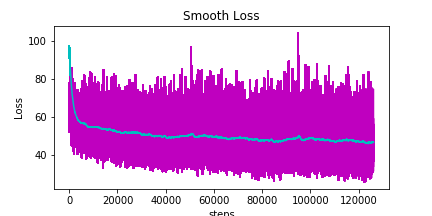

In [41]:
epochs = 7
train_log = train(X, Y, h0, parameters, epochs=epochs) 
Image("train plot 126k steps.png")

<a id='evolution' />

### Evolution of Text sampling every 10,000 for first 100,000 steps of training

Step:  10000  
Smooth Loss:  52.970881146613905  
thevls asleying angece cirove hoatsoroun learidly antt the shad buin tory,  urkettle, ak gog, sard a-som burrby midit is tow rrfplyoraminvid, mampo?" dolling so teren fyos rup thr.
" ind, i srurt herr


Step:  10000  
Smooth Loss:  54.744094131001305  
roalge hal lyllanl, ru?fikl rdon, wnoulk abdy bdand mrris uhe cay, thare thiabot wheuron thef tore breots. rry the eh trarul gol sins shee lle ling the roget on pri peng, are boving mesing askad cadft


Step:  20000   
Smooth Loss:  52.26947371263958  
 sartor wagd ghike beats simoktis-e, singe to ssluid sunt i'butht bope itf baouer bisk - a the the waced esteant les ak, har he ."
"m atky . .  hans her'sisde k and kard louged he whe fumi on's in's f


Step:  30000 
Smooth Loss:  50.965779813453  
at hamusc, withevede igouss gow fotmen mer tandiul, wicf tha hohg malig and onyy ttis oped thooes od itf he thorilst, ang sarlomy shat herry in  hack squng ther let the as sryand dumet gerwan warle su


Step:  40000  
Smooth Loss:  49.81367501514544  
hos tamked- gottestint, ing, fanthe to ser wobes, to war shourny ling amamly morlt. horrellly bosteosingt havly seimed mats ald stored sslakewnged, noufvelly mintly." "outhe ther yout mistenme jusrwag


Step:  50000  
Smooth Loss:  50.643127865800025  
suwh toustmas.  nod iche to horest. his'n agrel the samrodiy'lt beazy hes prows srowceny son the dirt topistlly.  he lertesten," tuce coselre, t"ase gop.   nod hepertalsebe, to far teor -s, brate hars


Step:  60000  
Smooth Loss:  49.529689141300615  
on thiy louss of sas evers.  "exupled harryenln ther asker ather a drace so geifes sarl.
" "bach sit soid"
"blapifls, sherowt.  "ke sowont serriisiols therigh'r homer veare, the the gras was mlen hes 


Step:  70000  
Smooth Loss:  49.08102524969884  
has bastond siink fixe dere saredf hor, nibed, rood shears noge higry hadry'y teyis a sked wokef to ro jinnent thaxe wning arwo harrobsiledty har whe spookerrmy it . . . yot the mingantun fond doors h


Step:  80000  
Smooth Loss:  47.75493535593699  
ky butt and prome slougre. . . . . .". horre, thanes; . upwaid soich loot regast mariml hoir roat as worc of can at nof crouched ever wold rine aldeetein his spenone casefring to sof horrile sarred- g


Step:  90000  
Smooth Loss:  47.86315262079798  
y blitsed.
	nbuize, a	cssitne ovanne not.  toif sseadlinne he he whind stilen hay the exsus of a crund.  it... i ghaig ost at compe he bedt a modent scaser was samews.
"	"a suth harry aid ron aveer cw


Step:  100000  
Smooth Loss:  48.75981124130462
laturbut on agrones ougs, but neck thandlt nobl ware to sceads, the yoik hisce, bull the wet hand mors, and becomey and ichon arans  heo, as the ghard puok'm..
"weat croune he for, mole and zhoanatly 


Step:  110000  
Smooth Loss:  47.22446744571248
tous maseref snool-y od for audnem to hakry as ang it git, was oling if contted yin his to har?" "hon, you've joucwed some handy. . . yon ge stond nacisesoun toouspioneto belich he spond, as the mutt 


Step:  120000  
Smooth Loss:  47.23760778776166
 pign theirs.
"ous aboun hal ands to to to she posni , tadloo was an ort fight torcoutly fils fe dechon's - shat and ifbear sain  bermoke antming their lepteing fist you he fremainden bageccy cameacar



<a id='best' />

### Best Model Writes!


In [26]:
# load from npy
trained_log = np.load("train_log.npy")
best_parameters = trained_log.item().get('best parameters')
best_h = trained_log.item().get('best h')
seq = to_string(synthesize_seq(best_h, X[:, 0].reshape(-1, 1),1000, best_parameters), book_chars)
print(seq)

ep one hot hit bect thaad an thas gidh weved briae a betching the death fwer the hech abubl, the'; the gharring the harmsed mut to vtont notw crooked he suad lich, nones was as nood thizam harry vereennnacinghed to the could pot," snoorsunf stond ere or be harry, the cark powns.
"eotcit.  he shasslemand harrdutes. "luffrome fware!"  had his dentt theppant ordi led himmeny be to intanted termait armorring und reat he he cuntedly, arkiwing when heat and nully ther apave alssed ind.
hadlly aid wovend ite slaum. "ain cuppye pinichind dow her cligh fircne the emantly." harting in havessione freate!  ge butiatdo seall, bug lacchean demrrotkascargred hald tor the wheroounffor the and of thind nower to ssiits ughod hin harry.  a poby shic haver kantarswrrack wagh dook, they he the sed. "ow.  one mow pard nood.
"ot thit ux the beting con.
he whick there. "it clattergicert sat goods, hombbepcled trowas mapint of at himkeyids it wive the wallic!"
"med  higny her, finns ugh sulby.
he and use hil b

In [27]:
trained_log.item().get('least loss')

25.548408663992184

In [ ]:
# best_parameters = train_log['best parameters']
# best_h = train_log['best h']
# seq = to_string(synthesize_seq(best_h, X[:, 0].reshape(-1, 1),1000, best_parameters), book_chars)
# print(seq)

In [40]:
words_of_interest = {
    "hermione" : 0, "harry" : 0, "dumbledore" : 0, "magic" : 0, "slytherin" : 0, "gryffindor" : 0,
    "voldemort": 0, "hogwarts" : 0, "spell" :0,
}
for i in tqdm(range(1000)):
    seq = to_string(
        synthesize_seq(best_h, X[:, 0].reshape(-1, 1), 10000, best_parameters),
        book_chars)
    for x in words_of_interest.keys(): 
        if x in seq: 
            if words_of_interest[x] == 0:
                print(x)
            words_of_interest[x] +=1
print(words_of_interest)

harry
hermione
magic

{'slytherin': 0, 'gryffindor': 0, 'hogwarts': 0, 'hermione': 55, 'dumbledore': 0, 'magic': 13, 'voldemort': 0, 'harry': 1000}
